# Análisis de componentes principales (PCA) para compresión de imágenes

Proyecto final - Métodos Multivariados
Mariana Luna Rocha 000195548 y Mauricio Vázquez Moran 

## I. Introducción

El análisis de componentes principales es una técnica utilizada en estadística y machine learning para **reducir la dimensionalidad** de conjuntos de datos con un alto número de variables. 

Al identificar las direcciones principales donde se encuentra la mayor variabilidad, PCA permite simplificar los datos manteniendo la información más relevante. Esta técnica es particularmente útil en problemas relacionados con imágenes, donde las dimensiones suelen ser muy altas debido al gran número de píxeles.

En este notebook, exploraremos cómo PCA puede ser aplicado a la compresión de imágenes, un proceso que busca representar una imagen en un espacio de menor dimensión mientras se conserva su esencia visual. Esto no solo reduce el tamaño del archivo, sino que también puede facilitar el procesamiento en tareas computacionalmente intensivas como el entrenamiento de modelos de machine learning.

La compresión de imágenes mediante *PCA* se basa en:

1. Identificar componentes principales que expliquen la mayor parte de la variabilidad en los valores de los píxeles.
2. Reducir la dimensionalidad utilizando únicamente un subconjunto de estos componentes principales.
3. Reconstruir la imagen a partir de los componentes seleccionados, comparando la calidad visual con la imagen original.

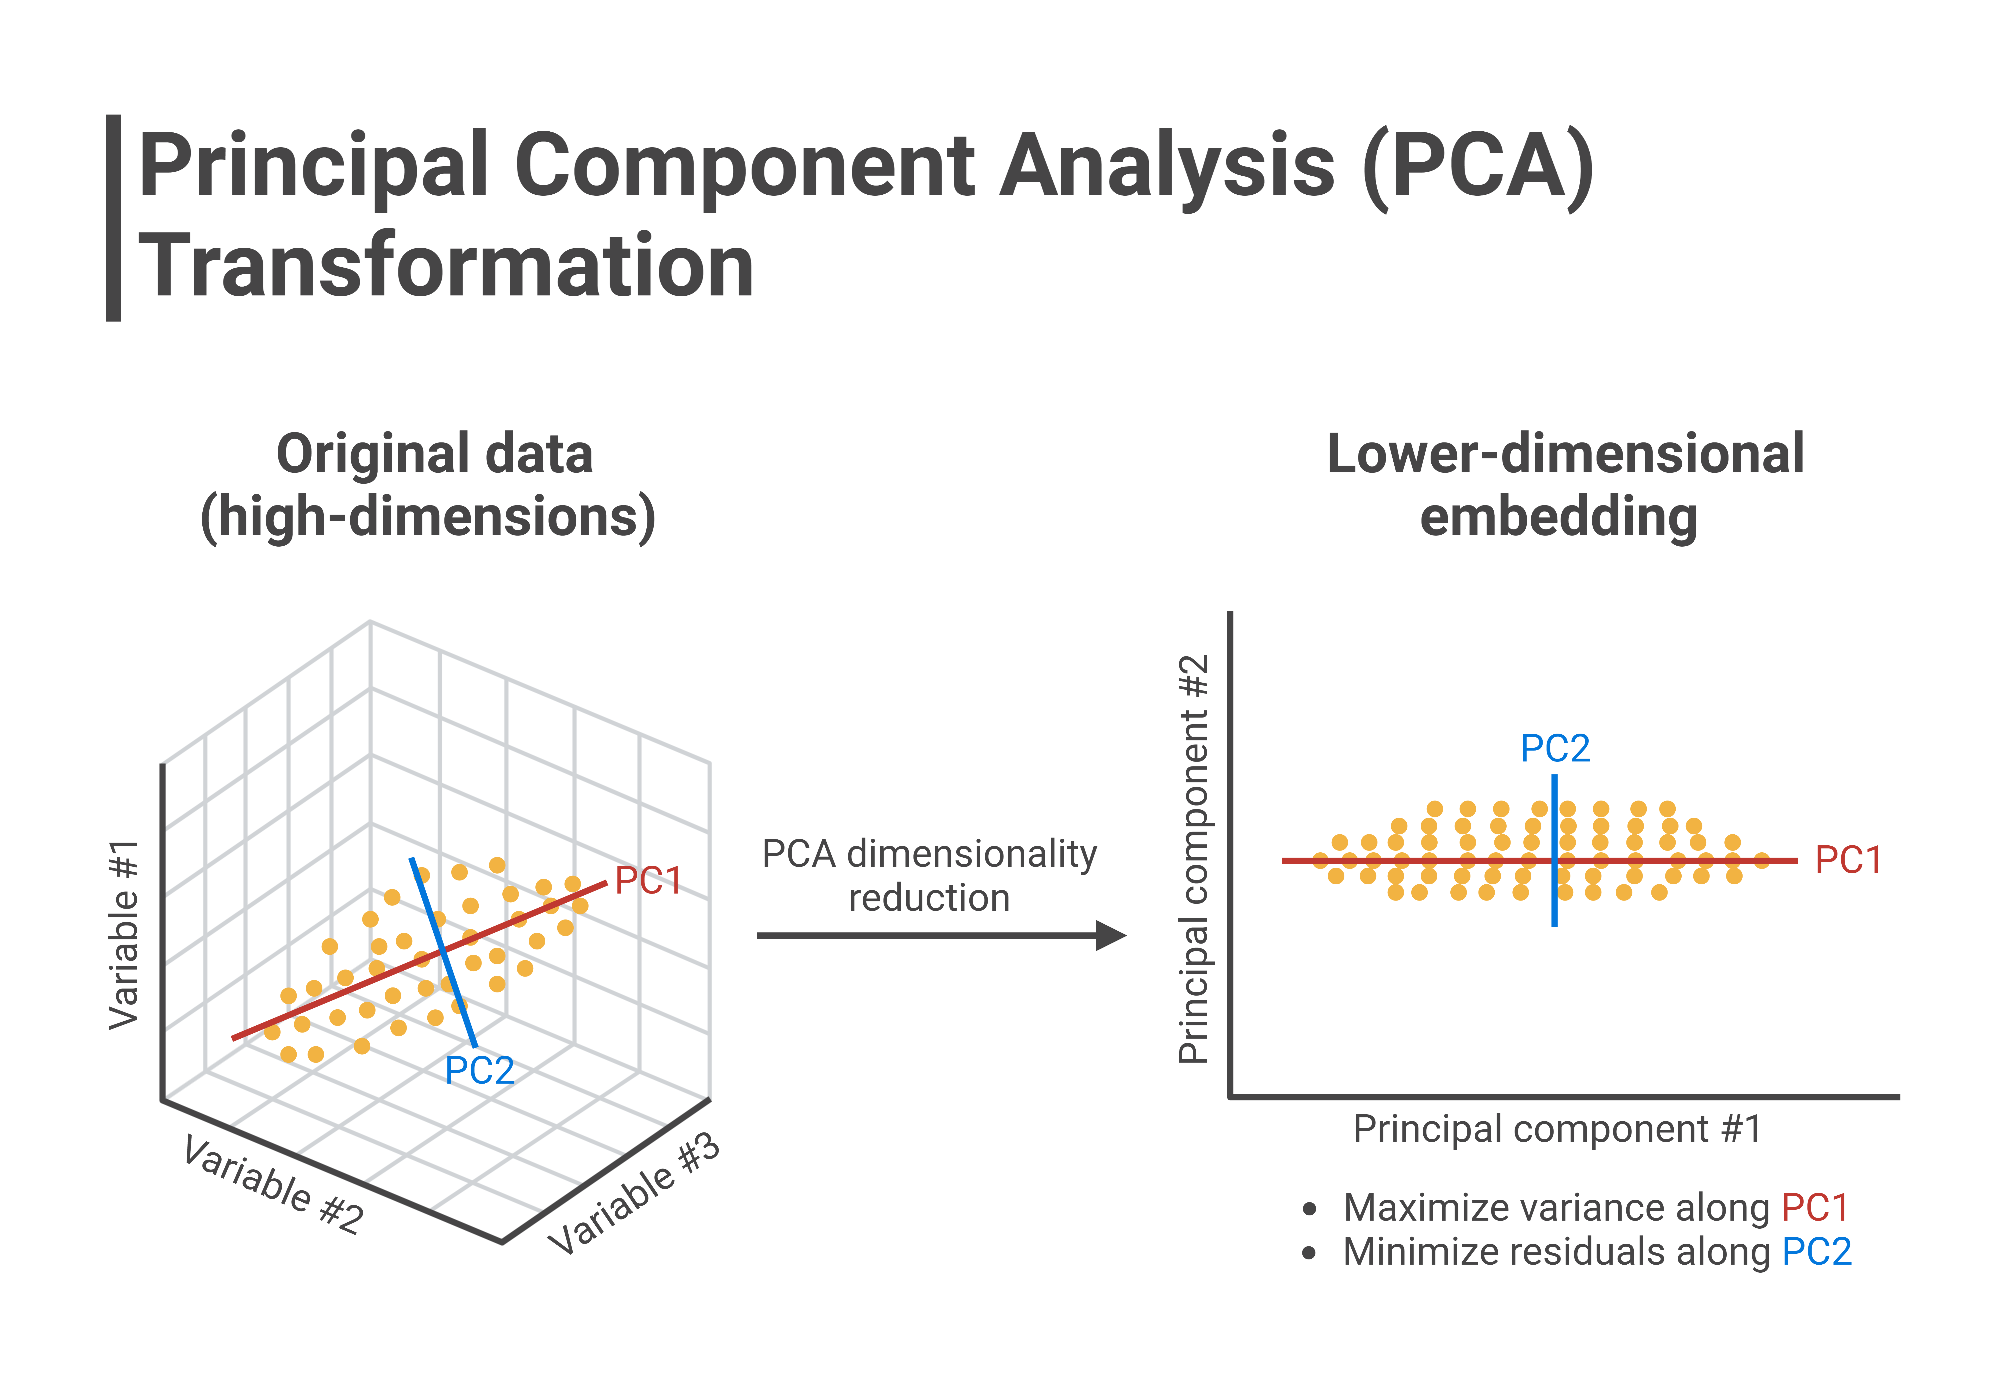

## II. Exploración de una imagen

En esta sección, introduciremos el concepto de imágenes como matrices numéricas y exploraremos cómo trabajar con ellas en Python.

Las imágenes son representaciones en forma de matrices, donde cada elemento de la matriz representa el valor de un píxel. En el caso de imágenes en color, estas matrices suelen tener tres dimensiones:

 - Altura: Número de píxeles verticales.
 - Anchura: Número de píxeles horizontales.
 - Canales de color (RGB): Tres matrices asociadas a los colores rojo, verde y azul.

Usaremos bibliotecas populares como *matplotlib* y *numpy* para cargar y visualizar una imagen. El proceso incluye:

- Cargar la imagen en formato matricial utilizando imread.
- Verificar las dimensiones de la matriz resultante.
- Visualizar la imagen en su forma original.

In [2]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

Dimensiones de la imagen original: alto de 800 pixeles, ancho de 1280 pixeles, y 3 canales de color (RGB)


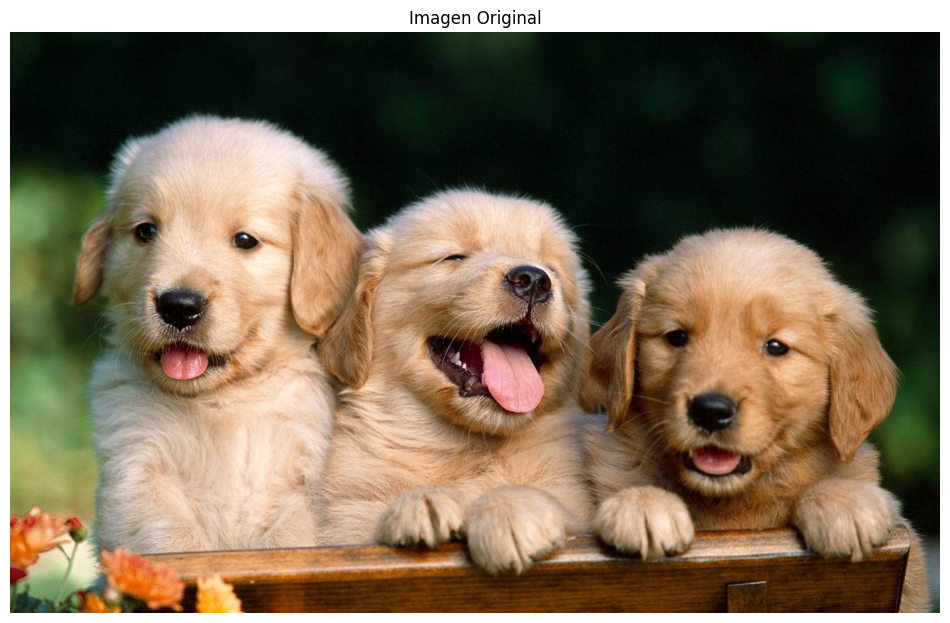

In [5]:
# Cargar y mostrar la imagen
image_raw = imread("perritos.jpeg")
print(f"Dimensiones de la imagen original: alto de {image_raw.shape[0]} pixeles, ancho de {image_raw.shape[1]} pixeles, y {image_raw.shape[2]} canales de color (RGB).")
plt.figure(figsize=(12, 8))
plt.title("Imagen Original")
plt.imshow(image_raw)
plt.axis('off')
plt.show()

#### Además, podemos visualizar el histograma de los pixeles de la imagen.

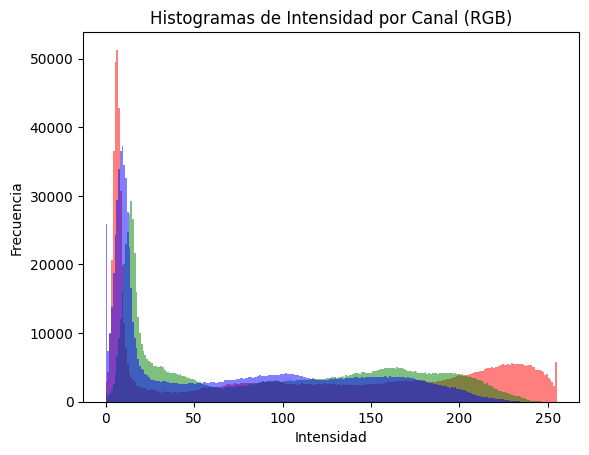

In [9]:
# Visualización de histograma para cada canal (Rojo, Verde, Azul)
colors = ('Red', 'Green', 'Blue')
plt.figure()
for i, color in enumerate(colors):
    plt.hist(image_raw[:, :, i].ravel(), bins=256, color=color.lower(), alpha=0.5)
plt.title("Histogramas de Intensidad por Canal (RGB)")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.show()

#### Para simplificar el análisis y reducir la dimensionalidad desde el principio, transformaremos la imagen de color (RGB) a escala de grises. 

Esto se hace combinando los valores de los canales de color en una única matriz bidimensional, donde cada valor representa la intensidad de un píxel (de 0 a 1):

 - 0 : Blanco (máxima intensidad).
 - 1 : Negro (mínima intensidad).

El proceso de conversión incluye:
1. Sumar los valores de los canales RGB para obtener un único valor de intensidad por píxel.
2. Normalizar los valores de la matriz para asegurarse de que estén en el rango de 0 a 1.

Dimensiones de la imagen transformada: alto de 800 pixeles, ancho de 1280 pixeles.


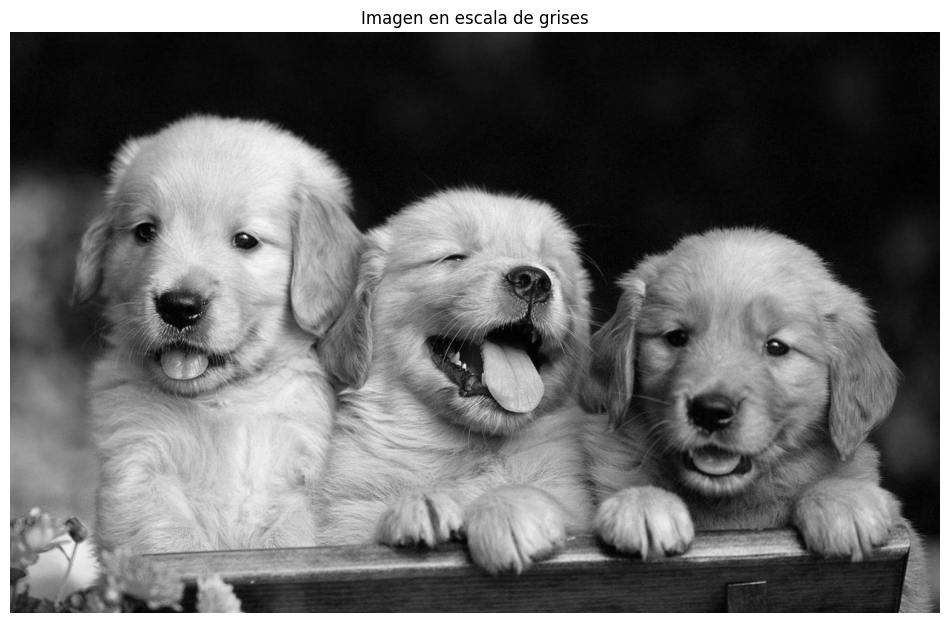

In [8]:
# Convertir a escala de grises
image_sum = image_raw.sum(axis=2)  # Suma los canales RGB
image_bw = image_sum / image_sum.max()  # Normaliza los valores
print(f"Dimensiones de la imagen transformada: alto de {image_raw.shape[0]} pixeles, ancho de {image_raw.shape[1]} pixeles.")

# Visualizar la imagen en escala de grises
plt.figure(figsize=(12, 8))
plt.title("Imagen en escala de grises")
plt.imshow(image_bw, cmap='gray')
plt.axis('off')
plt.show()

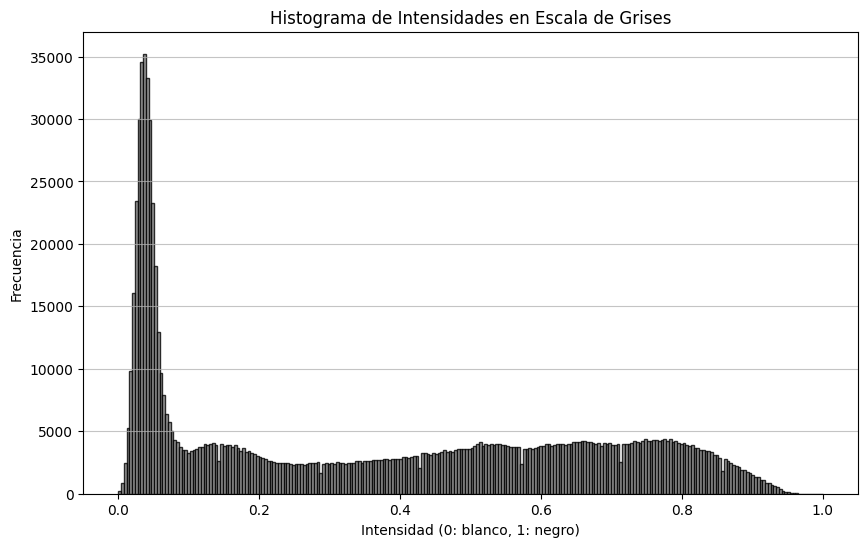

In [10]:
# Calcular el histograma de intensidades
plt.figure(figsize=(10, 6))
plt.hist(image_bw.ravel(), bins=256, color='gray', alpha=0.8, edgecolor='black')
plt.title("Histograma de Intensidades en Escala de Grises")
plt.xlabel("Intensidad (0: blanco, 1: negro)")
plt.ylabel("Frecuencia")
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Y también, podemos detectar los bordes de la imagen

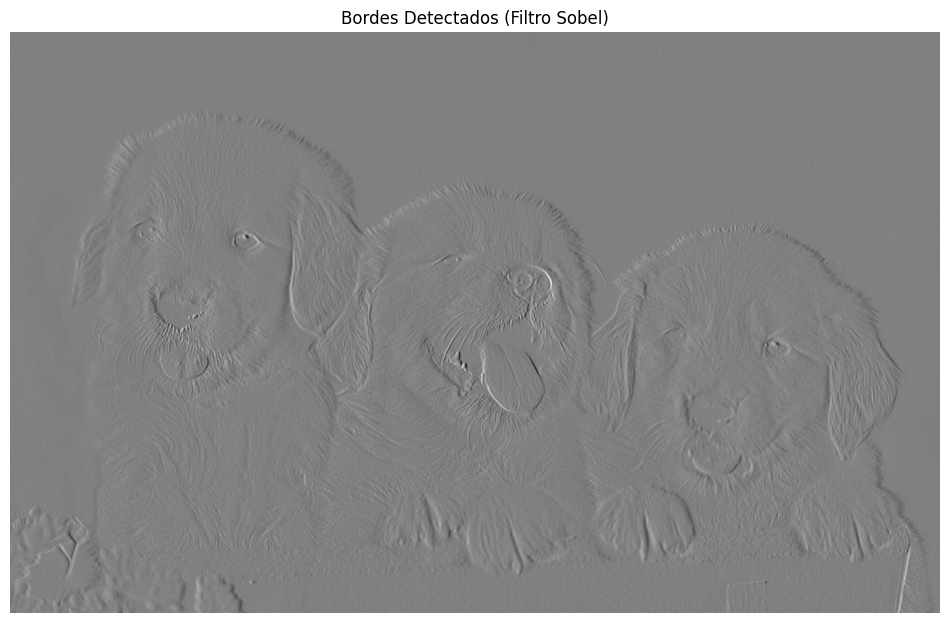

In [17]:
from scipy.ndimage import sobel

# Detectar bordes con el filtro de Sobel
sobel_edges = sobel(image_bw)

# Mostrar los bordes
plt.figure(figsize=(12, 8))
plt.title("Bordes Detectados (Filtro Sobel)")
plt.imshow(sobel_edges, cmap='gray')
plt.axis('off')
plt.show()

#### También podemos analizar algunas de las estadísticas descriptivas de la imagen

In [11]:
# Estadísticas descriptivas
mean_intensity = np.mean(image_bw)
median_intensity = np.median(image_bw)
std_intensity = np.std(image_bw)
min_intensity = np.min(image_bw)
max_intensity = np.max(image_bw)

print(f"Promedio de intensidad: {mean_intensity:.4f}")
print(f"Mediana de intensidad: {median_intensity:.4f}")
print(f"Desviación estándar: {std_intensity:.4f}")
print(f"Intensidad mínima: {min_intensity:.4f}")
print(f"Intensidad máxima: {max_intensity:.4f}")

Promedio de intensidad: 0.3658
Mediana de intensidad: 0.3403
Desviación estándar: 0.2935
Intensidad mínima: 0.0000
Intensidad máxima: 1.0000


In [13]:
# Dividir la imagen en 4 cuadrantes
h, w = image_bw.shape
quadrants = {
    "Superior izquierda": image_bw[:h//2, :w//2],
    "Superior derecha": image_bw[:h//2, w//2:],
    "Inferior izquierda": image_bw[h//2:, :w//2],
    "Inferior derecha": image_bw[h//2:, w//2:]
}

# Calcular estadísticas para cada cuadrante
for name, quadrant in quadrants.items():
    print(f"{name}: Promedio = {np.mean(quadrant):.4f}, Desviación Estándar = {np.std(quadrant):.4f}")

Superior izquierda: Promedio = 0.3460, Desviación Estándar = 0.3205
Superior derecha: Promedio = 0.1806, Desviación Estándar = 0.2658
Inferior izquierda: Promedio = 0.5595, Desviación Estándar = 0.2200
Inferior derecha: Promedio = 0.3772, Desviación Estándar = 0.2247


1. Superior izquierda:
Esta región corresponde a la cara del perrito del lado izquierdo. La variabilidad moderada sugiere que incluye tanto tonos claros (el pelaje) como oscuros (la nariz y los ojos), resultando en un promedio intermedio de intensidad.

2. Superior derecha:
Esta región incluye partes más oscuras del fondo. El bajo promedio y la baja variabilidad reflejan que aquí predominan tonos oscuros y uniformes.

3. Inferior izquierda:
Esta región incluye más detalles del cuerpo del perrito izquierdo, como el pelaje más claro, lo que explica el promedio de intensidad más alto y una menor variabilidad.

4. Inferior derecha:
Representa el área correspondiente al perrito derecho, que tiene tonos moderados y ligeramente más uniformes, lo que justifica el promedio y la desviación estándar observados.